In [1]:
import os
import pandas as pd
import numpy as np
import sklearn as sk
import warnings
import itertools as IT
import glob
import datetime as dt
import time
import sys

In [2]:
from dateutil.relativedelta import relativedelta

# from xgboost import plot_importance
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler


# #Common Model Algorithms
# from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
# import xgboost

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',500)
pd.set_option('max_info_columns',500)
pd.set_option('display.float_format', lambda x : '%.3f' % x )

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
#from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import NearMiss
#from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.model_selection import cross_val_score



In [4]:
data=pd.read_csv("PJT002_train.csv",encoding="UTF-8-sig")

data.shape

print('NON FIRE', round(data['fr_yn'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('FIRE', round(data['fr_yn'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

NON FIRE 87.07 % of the dataset
FIRE 12.93 % of the dataset


X = data.drop('fr_yn', axis=1)
y = data['fr_yn']
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

In [172]:
data.isnull().sum()

dt_of_fr                        0
fr_yn                           0
bldng_us                    27677
bldng_archtctr              27665
bldng_cnt                       0
                            ...  
us_yn                       49447
dngrs_thng_yn               49447
slf_fr_brgd_yn              49447
blk_dngrs_thng_mnfctr_yn    49447
cltrl_hrtg_yn               49447
Length: 180, dtype: int64

# 오브젝트 먼저 전처리

In [5]:
data.iloc[:,2].dtype=='O'

object_list=[]
for col in data:
    if data[col].dtype =="object":
        object_list.append(col)

In [6]:
# 수치형 데이터 따로 정리

object_data=data[object_list[:]]

numeric_list=list(set(data.columns.tolist()) - set(object_list))
numeric_list=sorted(numeric_list)
numeric_data=data[numeric_list[:]]


# 화재 발생 시기 데이터 타입 변경
object_data['dt_of_fr']=object_data['dt_of_fr'].astype('datetime64[ns]')

### bldng_us(사용용도)

In [7]:
object_data["주거용YN"]=object_data.lnd_us_sttn_nm.apply(lambda x: 1 if x =="단독" else x)
object_data["주거용YN"]=object_data.주거용YN.apply(lambda x: 1 if x =="연립" else x)
object_data["주거용YN"]=object_data.주거용YN.apply(lambda x: 1 if x =="아파트" else x)
object_data["주거용YN"]=object_data.주거용YN.apply(lambda x: 1 if x =="다세대" else x)
object_data["주거용YN"]=object_data.주거용YN.apply(lambda x: 1 if x =="주거기타" else x)
object_data['주거용YN']=object_data.주거용YN.apply(lambda x: 1 if x==1 else 0)


In [8]:
object_data["공업용YN"]=object_data.lnd_us_sttn_nm.apply(lambda x: 1 if x =="공업용" else x)
object_data["공업용YN"]=object_data.공업용YN.apply(lambda x: 1 if x =="공업기타" else x)
object_data["공업용YN"]=object_data.공업용YN.apply(lambda x: 1 if x =="발전소" else x)
object_data["공업용YN"]=object_data.공업용YN.apply(lambda x: 1 if x =="유해.혐오시설" else x)
object_data["공업용YN"]=object_data.공업용YN.apply(lambda x: 1 if x =="공업나지" else x)
object_data['공업용YN']=object_data.공업용YN.apply(lambda x: 1 if x==1 else 0)


In [9]:
object_data["농업용YN"]=object_data.lnd_us_sttn_nm.apply(lambda x: 1 if x =="자연림" else x)
object_data["농업용YN"]=object_data.농업용YN.apply(lambda x: 1 if x =="답" else x)
object_data["농업용YN"]=object_data.농업용YN.apply(lambda x: 1 if x =="전" else x)
object_data["농업용YN"]=object_data.농업용YN.apply(lambda x: 1 if x =="조림" else x)
object_data["농업용YN"]=object_data.농업용YN.apply(lambda x: 1 if x =="답기타" else x)
object_data["농업용YN"]=object_data.농업용YN.apply(lambda x: 1 if x =="과수원" else x)
object_data["농업용YN"]=object_data.농업용YN.apply(lambda x: 1 if x =="토지임야" else x)
object_data["농업용YN"]=object_data.농업용YN.apply(lambda x: 1 if x =="임야기타" else x)
object_data["농업용YN"]=object_data.농업용YN.apply(lambda x: 1 if x =="목장용지" else x)
object_data['농업용YN']=object_data.농업용YN.apply(lambda x: 1 if x==1 else 0)


In [10]:
사용현황_널값["lnd_us_sttn_nm"]=사용현황_널값.jmk.apply(lambda x: "단독" if x =="대" else x)

NameError: name '사용현황_널값' is not defined

In [ ]:
사용현황_널값["lnd_us_sttn_nm"]=사용현황_널값.lnd_us_sttn_nm.apply(lambda x: "주거기타" if x =="창" else x)

In [11]:
사용현황_널값["lnd_us_sttn_nm"]=사용현황_널값.lnd_us_sttn_nm.apply(lambda x: "상업용" if x =="잡" else x)


NameError: name '사용현황_널값' is not defined

In [230]:
사용현황_널값["lnd_us_sttn_nm"]=사용현황_널값.lnd_us_sttn_nm.apply(lambda x: "공업용" if x =="장" else x)

In [231]:
사용현황_널값["lnd_us_sttn_nm"]=사용현황_널값.lnd_us_sttn_nm.apply(lambda x: "주거나지" if x =="창" else x)

In [236]:
사용현황_널값["lnd_us_sttn_nm"]

90          답
106         도
184         천
247         구
328         도
         ... 
58962       목
58987       목
59001       목
59107    주거기타
59176       목
Name: lnd_us_sttn_nm, Length: 1776, dtype: object

In [264]:
object_data[object_data.lnd_us_sttn_nm.isnull()]["lnd_us_sttn_nm"].fillna(0,inplace=True)

In [271]:
object_data[object_data.lnd_us_sttn_nm.isnull()]["lnd_us_sttn_nm"]

90       NaN
106      NaN
184      NaN
247      NaN
328      NaN
        ... 
58962    NaN
58987    NaN
59001    NaN
59107    NaN
59176    NaN
Name: lnd_us_sttn_nm, Length: 1776, dtype: object

In [295]:
object_data[object_data.lnd_us_sttn_nm.isnull()]["lnd_us_sttn_nm"].apply(사용현황_널값["lnd_us_sttn_nm"],axis=1)

TypeError: 'Series' object is not callable

In [278]:

object_data[object_data.lnd_us_sttn_nm.isnull()]["lnd_us_sttn_nm"]=object_data[object_data.lnd_us_sttn_nm.isnull()]["lnd_us_sttn_nm"].fillna(사용현황_널값["lnd_us_sttn_nm"],axis='index')

In [281]:
object_data[object_data.lnd_us_sttn_nm.isnull()]["lnd_us_sttn_nm"]=object_data[object_data.lnd_us_sttn_nm.isnull()]["lnd_us_sttn_nm"].astype('str')

In [279]:
object_data[object_data.lnd_us_sttn_nm.isnull()]["lnd_us_sttn_nm"].replace(NaN,사용현황_널값["lnd_us_sttn_nm"])

90       NaN
106      NaN
184      NaN
247      NaN
328      NaN
        ... 
58962    NaN
58987    NaN
59001    NaN
59107    NaN
59176    NaN
Name: lnd_us_sttn_nm, Length: 1776, dtype: object

In [211]:
data.groupby("jmk").size().sort_values(ascending=False)

jmk
대    45515
전     2302
답     2267
장     1971
잡     1389
창     1179
임     1163
목      946
도      620
종      391
학      364
구      239
과      161
천      133
주      117
양       69
차       64
체       54
묘       53
원       40
철       38
유       36
공       30
제       25
수       23
사       10
dtype: int64

In [222]:
# jmk로 토지 이용을 채우고, 토지 이용으로 새로운 더미 변수 치환하는 방식 적용

object_data[["lnd_us_sttn_nm","jmk"]][object_data["lnd_us_sttn_nm"].notnull()][object_data[["lnd_us_sttn_nm","jmk"]][object_data["lnd_us_sttn_nm"].notnull()]["lnd_us_sttn_nm"]=="주거나지"].groupby("jmk").size()



jmk
구      1
답     80
대    872
도      1
목      3
묘      1
양      3
유      1
임     15
잡     57
장      2
전    103
종      2
주      1
차      2
창      5
천      3
철      2
학      5
dtype: int64

In [191]:
object_data.groupby("lnd_us_sttn_nm").size().sort_values(ascending=False)

lnd_us_sttn_nm
단독          34739
주거기타         3966
상업용          3191
주상용          2957
공업용          2000
전            1525
답            1291
주거나지         1159
답기타          1081
전기타           826
아파트           737
자연림           719
주상기타          471
도로등           358
과수원           276
상업기타          258
업무용           231
다세대           229
주상나지          189
공업기타          147
연립            144
상업나지          142
하천등           133
토지임야          125
공업나지          115
임야기타           75
조림             63
주차장등           48
공원등            43
기타             41
운동장등           37
유해.혐오시설        35
목장용지           21
고속도로휴게소        15
여객자동차터미널       12
골프장 회원제         8
위험시설            5
유원지             3
특수기타            2
공원묘지            2
콘도미니엄           1
발전소             1
골프장 대중제         1
스키장             1
dtype: int64

# object_data.fr_yn=object_data.fr_yn.apply(lambda x: 1 if x=="Y" else 0)

# 사용 용도에 따라 주거시설/편의시설 여부로 더미화

object_data.bldng_us.unique()

object_data['주거시설YN']=object_data.bldng_us.apply(lambda x: 1 if x=="단독주택" else x)
object_data['주거시설YN']=object_data.주거시설YN.apply(lambda x: 1 if x=="공동주택" else x)
object_data['주거시설YN']=object_data.주거시설YN.apply(lambda x: 1 if x==1 else 0)

In [12]:
object_data['편의시설YN']=object_data.bldng_us.apply(lambda x: 1 if x=="제1종근린생활시설" else x)
object_data['편의시설YN']=object_data.편의시설YN.apply(lambda x: 1 if x=="제2종근린생활시설" else x)
object_data['편의시설YN']=object_data.편의시설YN.apply(lambda x: 1 if x=="문화및집회시설" else x)
object_data['편의시설YN']=object_data.편의시설YN.apply(lambda x: 1 if x==1 else 0)

object_data.groupby("bldng_us").size().sort_values(ascending=False)

In [13]:
# 6자리 혹은 nan 혹은 10자리임을 알 수 있음.
#  sns.distplot(object_data.dt_of_athrztn.astype(str).apply(len))

### dt_of_athrztn(건물승인일자)

In [14]:
# 건축 날짜의 데이터 타입이 2종류, 따라서 이 모양을 연도 형식으로 바꾸어줄 필요가 있음.

object_data.dt_of_athrztn=object_data.dt_of_athrztn.apply(lambda x: str(x)[0:4] if len(str(x))==10 else x)
object_data.dt_of_athrztn=object_data.dt_of_athrztn.apply(lambda x: str(x)[0:4] if len(str(x))==8 else x)
object_data.dt_of_athrztn=object_data.dt_of_athrztn.apply(lambda x: str(x)[0:4] if len(str(x))==6 else x)

In [15]:
dirty_date_idx=object_data.dt_of_athrztn[object_data.dt_of_athrztn.astype(str).apply(len)>4].index

In [16]:
object_data.dt_of_athrztn[dirty_date_idx[0]]="1980"
object_data.dt_of_athrztn[dirty_date_idx[1]]="1890"
object_data.dt_of_athrztn[dirty_date_idx[2]]="1890"
object_data.dt_of_athrztn[dirty_date_idx[3]]="1990"
object_data.dt_of_athrztn[dirty_date_idx[4]]="1990"
object_data.dt_of_athrztn[dirty_date_idx[5]]="1982"
object_data.dt_of_athrztn[dirty_date_idx[6]]="1978"
object_data.dt_of_athrztn[dirty_date_idx[7]]="1994"

#결측치가 아닌 연도 데이터를 시각화 하는 코드

#sns.distplot(object_data.dt_of_athrztn[~(object_data.dt_of_athrztn.isna)()].astype(int))

말도안돼_연도=object_data.dt_of_athrztn[~(object_data.dt_of_athrztn.isna)()].astype(int)[object_data.dt_of_athrztn[~(object_data.dt_of_athrztn.isna)()].astype(int)>2019].index

object_data.dt_of_athrztn[말도안돼_연도]="1997"

있는_연도=object_data.dt_of_athrztn[~(object_data.dt_of_athrztn.isna())].astype(int)

In [17]:
object_data.dt_of_athrztn.fillna("1988",inplace=True)

In [18]:
object_data.dt_of_athrztn=object_data.dt_of_athrztn.astype(int)

In [19]:
object_data["건물연령"]=object_data.dt_of_athrztn.apply(lambda x: 2019-x)

### rd_sd_nm(도로측면명)

In [20]:
object_data.rd_sd_nm.unique()

array(['세로한면(불)', '세로한면(가)', '중로한면', '소로한면', '맹지', '광대로한면', '세로각지(불)',
       '중로각지', '세로각지(가)', '소로각지', nan, '광대세각', '광대소각', '지정되지않음'],
      dtype=object)

data.isnull().sum(axis=1)[data.isnull().sum(axis=1)<150].index

In [21]:
object_data['차량통행YN']=object_data.rd_sd_nm.apply(lambda x: 1 if x=="세로한면(가)" else x)
object_data['차량통행YN']=object_data.차량통행YN.apply(lambda x: 1 if x=="세로각지(가)" else x)
object_data['차량통행YN']=object_data.차량통행YN.apply(lambda x: 1 if x=="소로각지" else x)
object_data['차량통행YN']=object_data.차량통행YN.apply(lambda x: 1 if x=="중로한면" else x)
object_data['차량통행YN']=object_data.차량통행YN.apply(lambda x: 1 if x=="중로각지" else x)
object_data['차량통행YN']=object_data.차량통행YN.apply(lambda x: 1 if x=="소로한면" else x)
object_data['차량통행YN']=object_data.차량통행YN.apply(lambda x: 1 if x==1 else 0)

In [22]:
object_data['대로인접YN']=object_data.rd_sd_nm.apply(lambda x: 1 if x=="중로각지" else x)
object_data['대로인접YN']=object_data.대로인접YN.apply(lambda x: 1 if x=="중로한면" else x)
object_data['대로인접YN']=object_data.대로인접YN.apply(lambda x: 1 if x=="광대세각" else x)
object_data['대로인접YN']=object_data.대로인접YN.apply(lambda x: 1 if x=="광대소각" else x)
object_data['대로인접YN']=object_data.대로인접YN.apply(lambda x: 1 if x=="광대로한면" else x)
object_data['대로인접YN']=object_data.대로인접YN.apply(lambda x: 1 if x==1 else 0)

### bldng_archtctr(건물구조)

In [23]:
object_data['목재구조YN']=object_data.bldng_archtctr.apply(lambda x: 1 if x=="일반목구조" else x)
object_data['목재구조YN']=object_data.목재구조YN.apply(lambda x: 1 if x=="통나무구조" else x)
object_data['목재구조YN']=object_data.목재구조YN.apply(lambda x: 1 if x=="목구조" else x)
object_data['목재구조YN']=object_data.목재구조YN.apply(lambda x: 1 if x==1 else 0)

### bldng_us_clssfctn(건물용도분류명)

### rgnl_ar_nm(용도지역지구명)

In [24]:
object_data.rgnl_ar_nm.unique()

array(['자연녹지지역', '계획관리지역', '제2종일반주거지역', '제1종일반주거지역', '자연환경보전지역', '보전관리지역',
       '일반상업지역', '생산관리지역', '준주거지역', '생산녹지지역', '농림지역', nan, '준공업지역',
       '일반공업지역', '근린상업지역', '제1종전용주거지역', '개발제한구역', '제3종일반주거지역',
       '제2종전용주거지역', '보전녹지지역', '유통상업지역', '중심상업지역', '관리지역', '용도미지정'],
      dtype=object)

In [25]:
object_data.groupby("rgnl_ar_nm").size().sort_values(ascending=False)

rgnl_ar_nm
계획관리지역       25552
제2종일반주거지역     9967
제1종일반주거지역     4438
자연녹지지역        3399
일반상업지역        3043
생산관리지역        2103
농림지역          2024
보전관리지역        1982
일반공업지역         902
제3종일반주거지역      827
제1종전용주거지역      751
자연환경보전지역       708
준주거지역          614
생산녹지지역         414
준공업지역          400
개발제한구역         252
보전녹지지역         157
제2종전용주거지역       72
근린상업지역          53
유통상업지역          28
중심상업지역          16
관리지역             4
용도미지정            2
dtype: int64

In [26]:
object_data.bldng_us_clssfctn.unique()

array(['주거용', nan, '상업용', '문교사회용', '공업용', '농수산용', '기타', '공공용'],
      dtype=object)

In [27]:
object_data.groupby("bldng_us_clssfctn").size().sort_values(ascending=False)

bldng_us_clssfctn
주거용      19589
상업용       5389
기타        1899
농수산용      1225
공업용       1043
문교사회용      677
공공용         34
dtype: int64

In [28]:
object_data['주거용YN']=object_data.bldng_us_clssfctn.apply(lambda x: 1 if x=="주거용" else 0)

In [29]:
object_data['target_value']=object_data.fr_yn.apply(lambda x: 1 if x=="Y" else 0)

### emd_nm(행정구역명) 데이터

sns.distplot(object_data.emd_nm.astype(str).apply(len))

In [30]:
object_data.emd_nm[object_data.emd_nm.astype(str).apply(len)[object_data.emd_nm.astype(str).apply(len)<4].index]


17885    NaN
20869    NaN
52035    NaN
58625    NaN
Name: emd_nm, dtype: object

In [31]:
object_data.emd_nm=object_data.emd_nm.str[4:]

In [32]:
object_data.emd_nm[object_data.emd_nm.notnull()]

0            창녕군 창녕읍
1            의령군 가례면
2            창녕군 창녕읍
3         창원시의창구 대산면
4            창녕군 창녕읍
            ...     
59194        함안군 칠원읍
59195        함안군 칠원읍
59196        함안군 법수면
59197        함안군 대산면
59198        창녕군 대지면
Name: emd_nm, Length: 59195, dtype: object

In [33]:
object_data.emd_nm[object_data.emd_nm.isnull()]

17885    NaN
20869    NaN
52035    NaN
58625    NaN
Name: emd_nm, dtype: object

In [34]:
object_data["시YN"]=object_data.emd_nm[object_data.emd_nm.notnull()].apply(lambda x: "1" if x[3]=="시" else "0")

In [35]:
object_data.groupby("emd_nm").size().sort_values(ascending=False).sample(100)

emd_nm
 남해군 남해읍 입현리            1
 진주시 금산면              217
 거제시 하청면              247
 창원시 마산합포구 완월동          1
 창원시의창구 봉림동           336
 함안군 칠원읍 운곡리            3
 창원시성산구 반송동           126
 창녕군 도천면              199
 거창군 거창읍              897
 함양군 마천면              183
 창녕군 대합면 목단리            2
 진주시 상평동              294
 진주시 이반성면             184
 거제시 옥포1동              84
 창원시진해구 충무동            78
 창원시마산합포구 오동동         194
 진주시 정촌면              181
 합천군 가야면              313
 거창군 북상면              137
 고성군 거류면              356
 남해군 서면               267
 진주시 명석면              253
 진주시 상봉동              266
 의령군 가례면              139
 창원시마산회원구 내서읍         288
 남해군 삼동면              338
 통영시 욕지면 두미리            1
 함안군 칠원읍              320
 밀양시 삼문동              163
 합천군 청덕면              169
 창원시성산구 중앙동           110
 양산시 덕계동              107
 창원시 마산합포구 진전면 창포리      1
 창녕군 계성면              201
 하동군 악양면              287
 함양군 서상면              176
 거창군 마리면              182
 함안군 칠원읍 유원리            2
 하동군 

# 수치형 데이터

In [36]:
numeric_list_not_engry=[s for s in numeric_list if not "engry" in s]


In [37]:
numeric_data_on=numeric_data.loc[:,numeric_list_not_engry]

In [38]:
numeric_data_on.describe()

,ahsm_dstnc,bldng_ar,bldng_ar_prc,bldng_cnt,bldng_cnt_in_50m,cctv_dstnc,cctv_in_100m,fr_mn_cnt,fr_sttn_dstnc,fr_wthr_fclt_dstnc,fr_wthr_fclt_in_100m,hm_cnt,hmdt,id,lnd_ar,lw_13101010,lw_13101110,lw_13101210,lw_13101211,lw_13101310,lw_13101410,lw_13111010,lw_13111110,lw_13121010,lw_13121011,lw_13131010,lw_13131110,lw_13141010,lw_13141011,no_tbc_zn_dstnc,prcpttn,sft_emrgnc_bll_dstnc,tbc_rtl_str_dstnc,tmprtr,ttl_ar,ttl_dwn_flr,ttl_grnd_flr,wnd_drctn,wnd_spd
count,59199.000,59199.000,37304.000,59199.000,59199.000,59199.000,59199.000,59158.000,59199.000,59199.000,59199.000,58498.000,59177.000,59199.000,59199.000,302.000,291.000,297.000,298.000,292.000,283.000,300.000,281.000,273.000,273.000,296.000,296.000,292.000,291.000,59199.000,5570.000,59199.000,59199.000,59186.000,59199.000,48194.000,48989.000,58978.000,59166.000
mean,8974.287,633.563,639759.631,3.454,3.815,760.095,0.415,151.219,5738.526,1910.027,0.246,10921.538,65.848,103558.890,29000.264,3.465,3.133,3.529,3.456,3.317,1.693,3.711,1.654,0.408,0.393,2.930,2.930,2.707,2.778,1146.475,1.722,31396.046,3253.293,14.016,2477.958,0.132,3.193,159.750,1.535
std,11377.904,9211.774,493829.723,7.221,8.410,1337.103,1.177,36.763,4908.276,2638.502,0.609,12858.179,23.510,19921.312,2157306.099,0.583,1.275,0.702,0.967,1.142,1.616,0.680,1.747,1.077,1.040,1.219,1.219,1.516,1.490,1671.200,3.989,24248.944,3329.986,9.786,78319.359,1.002,16.301,125.752,1.298
min,0.000,0.000,17537.000,1.000,0.000,0.000,0.000,85.000,4.000,0.000,0.000,778.000,0.000,69056.000,0.000,1.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,-14.100,0.000,0.000,0.000,0.000,0.000
25%,761.000,46.280,274865.000,1.000,0.000,100.000,0.000,112.000,1651.000,114.000,0.000,2880.000,48.000,86303.500,0.000,3.000,3.000,3.000,3.000,3.000,0.000,3.477,0.000,0.000,0.000,2.737,2.737,2.073,2.469,115.000,0.000,11229.000,527.000,6.100,50.550,0.000,1.000,20.000,0.600
50%,3210.000,87.730,550517.500,2.000,0.000,288.000,0.000,161.000,4444.000,643.000,0.000,5740.000,68.000,103561.000,160.000,3.500,3.500,4.000,4.000,4.000,2.000,4.000,0.000,0.000,0.000,3.000,3.000,3.000,3.000,422.000,0.400,27037.000,2184.000,14.700,97.200,0.000,1.000,160.000,1.200
75%,14239.500,155.100,864379.250,4.000,3.000,889.000,0.000,176.000,8603.000,2494.000,0.000,13501.000,87.000,120781.500,446.000,4.000,4.000,4.000,4.000,4.000,3.000,4.000,3.409,0.000,0.000,4.000,4.000,4.000,4.000,1486.500,1.500,45713.000,4958.000,22.000,214.415,0.000,2.000,270.000,2.200
max,56485.000,572897.955,15689300.000,705.000,84.000,12278.000,24.000,210.000,38044.000,17716.000,10.000,115081.000,100.000,138108.000,203898366.000,5.000,5.000,6.000,5.500,5.000,5.000,5.000,5.000,4.000,4.000,5.000,5.000,5.000,5.000,16164.000,93.000,103571.000,23228.000,38.100,12351844.468,60.000,594.000,360.000,15.300


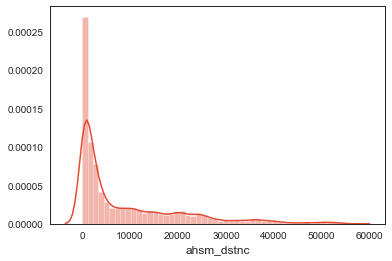

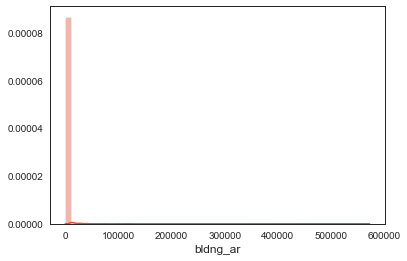

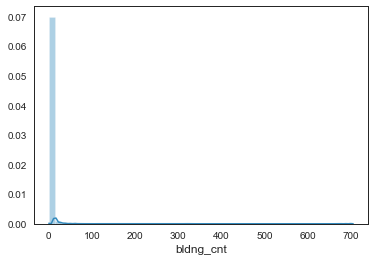

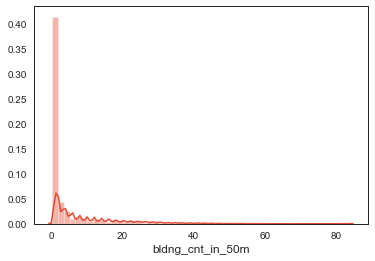

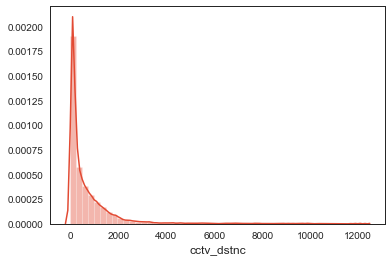

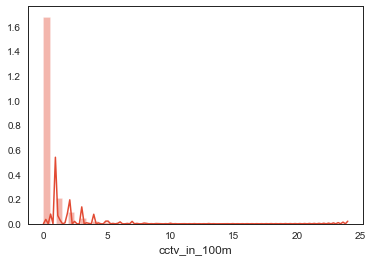

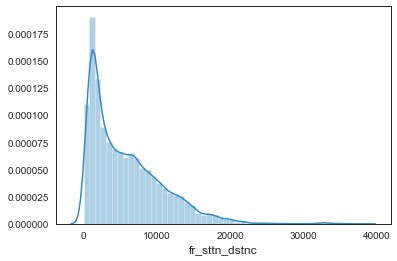

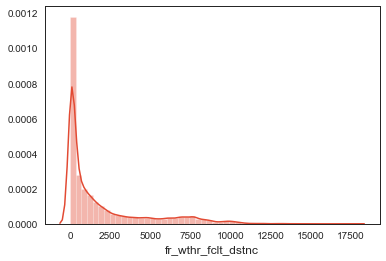

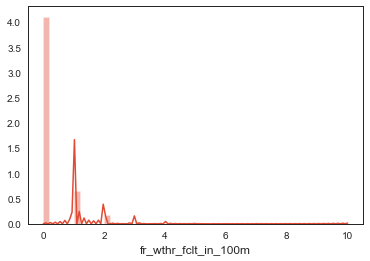

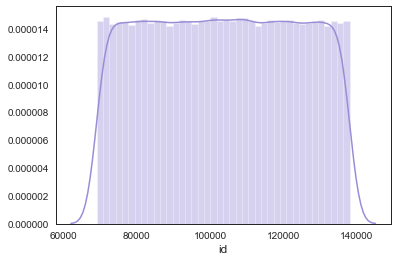

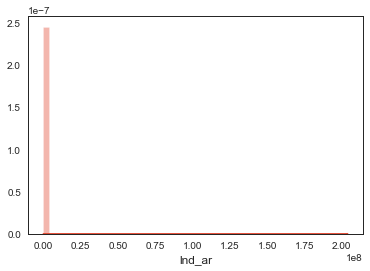

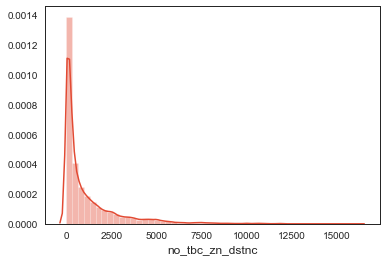

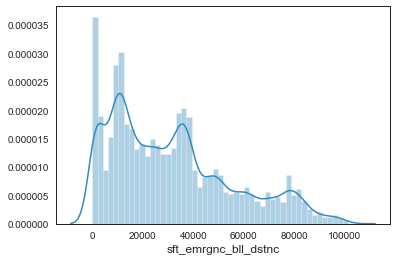

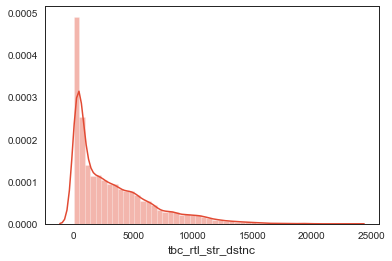

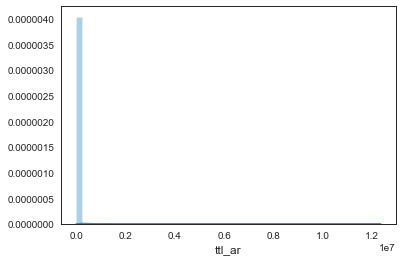

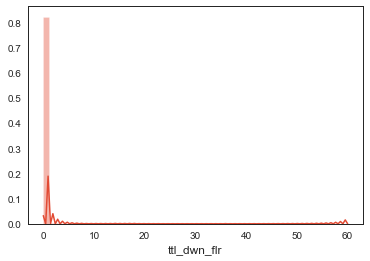

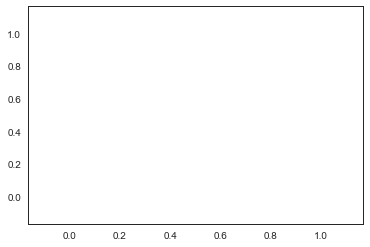

In [39]:
for col in numeric_data_on:
    try:
        if data[col].dtype !='object':
            sns.distplot(data[col],label=col)
            plt.show()
    except ValueError:
        pass
    
    

In [40]:
DF=object_data.join(numeric_data_on)

In [42]:
DF.columns

Index(['dt_of_fr', 'fr_yn', 'bldng_us', 'bldng_archtctr', 'dt_of_athrztn', 'bldng_us_clssfctn', 'jmk', 'rgnl_ar_nm', 'rgnl_ar_nm2', 'lnd_us_sttn_nm', 'rd_sd_nm', 'emd_nm', 'mlt_us_yn', 'trgt_crtr', 'fr_fghtng_fclt_spcl_css_5_yn', 'fr_fghtng_fclt_spcl_css_6_yn', 'us_yn', 'dngrs_thng_yn', 'slf_fr_brgd_yn', 'blk_dngrs_thng_mnfctr_yn', 'cltrl_hrtg_yn', '주거용YN', '공업용YN', '농업용YN', '편의시설YN', '건물연령', '차량통행YN', '대로인접YN', '목재구조YN', 'target_value', '시YN', 'ahsm_dstnc', 'bldng_ar', 'bldng_ar_prc',
       'bldng_cnt', 'bldng_cnt_in_50m', 'cctv_dstnc', 'cctv_in_100m', 'fr_mn_cnt', 'fr_sttn_dstnc', 'fr_wthr_fclt_dstnc', 'fr_wthr_fclt_in_100m', 'hm_cnt', 'hmdt', 'id', 'lnd_ar', 'lw_13101010', 'lw_13101110', 'lw_13101210', 'lw_13101211', 'lw_13101310', 'lw_13101410', 'lw_13111010', 'lw_13111110', 'lw_13121010', 'lw_13121011', 'lw_13131010', 'lw_13131110', 'lw_13141010', 'lw_13141011', 'no_tbc_zn_dstnc', 'prcpttn', 'sft_emrgnc_bll_dstnc', 'tbc_rtl_str_dstnc', 'tmprtr', 'ttl_ar', 'ttl_dwn_flr',
       't

In [67]:
data=DF.drop(["dt_of_fr","fr_yn","bldng_us","bldng_archtctr","dt_of_athrztn","bldng_us_clssfctn","jmk","rgnl_ar_nm","rgnl_ar_nm2","lnd_us_sttn_nm","rd_sd_nm","emd_nm","mlt_us_yn",\
             "trgt_crtr","fr_fghtng_fclt_spcl_css_5_yn","fr_fghtng_fclt_spcl_css_6_yn","us_yn","dngrs_thng_yn","slf_fr_brgd_yn","blk_dngrs_thng_mnfctr_yn","cltrl_hrtg_yn"],axis=1)

In [68]:
data.fillna(0,inplace=True)

In [69]:
data_index=data["id"]

data=data.set_index("id")

In [70]:
# 스케일링 후 다시 칼럼 네임 붙이기
colnames=data.columns

transformer = RobustScaler().fit(data)
data=transformer.transform(data)


data=pd.DataFrame(data)

data.columns=colnames

In [50]:
print('NON FIRE', round(data['target_value'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('FIRE', round(data['target_value'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

X = data.drop('target_value', axis=1)
y = data['target_value']

NON FIRE 87.07 % of the dataset
FIRE 12.93 % of the dataset


# Feature Selection

[2.64497107e-02 1.68625960e-02 4.59742401e-03 2.90570781e-02
 7.45844637e-02 1.19308623e-02 1.90305632e-02 9.02370904e-03
 1.00028746e-02 3.93083529e-02 5.47930689e-02 2.85918559e-02
 3.37104980e-02 2.54910571e-02 3.31720519e-02 1.54582967e-02
 2.74311463e-02 3.40770050e-02 5.12323280e-02 1.59282284e-02
 3.57491186e-02 4.99859365e-02 3.65989361e-02 5.69996111e-04
 1.16980660e-03 1.22658033e-03 1.21957167e-03 5.17854152e-04
 4.38359958e-04 5.25375226e-04 4.48551320e-04 2.87212199e-05
 6.40442318e-05 8.19160936e-04 4.52251632e-04 5.12913177e-04
 4.95109624e-04 3.49896044e-02 7.44198122e-03 3.50261328e-02
 3.46005515e-02 3.55032757e-02 4.80739756e-02 1.13201543e-02
 3.34825721e-02 3.14648698e-02 3.65414243e-02]


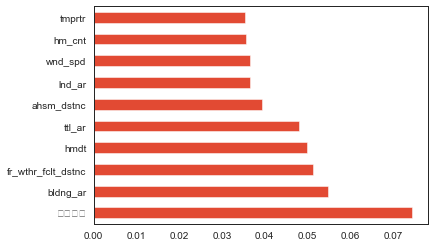

In [51]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [55]:
feat_importances.sort_values(ascending=False)

건물연령                   0.075
bldng_ar               0.055
fr_wthr_fclt_dstnc     0.051
hmdt                   0.050
ttl_ar                 0.048
ahsm_dstnc             0.039
lnd_ar                 0.037
wnd_spd                0.037
hm_cnt                 0.036
tmprtr                 0.036
sft_emrgnc_bll_dstnc   0.035
no_tbc_zn_dstnc        0.035
tbc_rtl_str_dstnc      0.035
fr_sttn_dstnc          0.034
bldng_cnt              0.034
ttl_grnd_flr           0.033
cctv_dstnc             0.033
wnd_drctn              0.031
편의시설YN                 0.029
bldng_ar_prc           0.029
fr_mn_cnt              0.027
주거용YN                  0.026
bldng_cnt_in_50m       0.025
대로인접YN                 0.019
공업용YN                  0.017
fr_wthr_fclt_in_100m   0.016
cctv_in_100m           0.015
차량통행YN                 0.012
ttl_dwn_flr            0.011
시YN                    0.010
목재구조YN                 0.009
prcpttn                0.007
농업용YN                  0.005
lw_13101210            0.001
lw_13101211   

In [77]:
중요_변수_리스트=feat_importances[feat_importances>0.002].index.tolist()

In [79]:
중요_변수_리스트.append("target_value")

In [81]:
data[중요_변수_리스트]

,주거용YN,공업용YN,농업용YN,편의시설YN,건물연령,차량통행YN,대로인접YN,목재구조YN,시YN,ahsm_dstnc,bldng_ar,bldng_ar_prc,bldng_cnt,bldng_cnt_in_50m,cctv_dstnc,cctv_in_100m,fr_mn_cnt,fr_sttn_dstnc,fr_wthr_fclt_dstnc,fr_wthr_fclt_in_100m,hm_cnt,hmdt,lnd_ar,no_tbc_zn_dstnc,prcpttn,sft_emrgnc_bll_dstnc,tbc_rtl_str_dstnc,tmprtr,ttl_ar,ttl_dwn_flr,ttl_grnd_flr,wnd_drctn,wnd_spd,target_value
0,1.000,0.000,0.000,0.000,1.833,-1.000,0.000,0.000,-1.000,0.602,-0.168,-0.351,0.333,0.000,-0.223,0.000,-0.375,0.015,-0.214,0.000,1.097,0.718,-0.359,-0.244,0.000,0.064,-0.066,-0.252,-0.170,0.000,0.000,0.160,-0.187,1.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,0.012,-0.381,-0.169,0.333,0.000,0.672,0.000,-1.188,0.280,-0.065,0.000,-0.369,0.154,-0.359,5.326,0.000,-0.190,0.530,0.302,-0.311,0.000,0.000,-0.560,-0.437,0.000
2,1.000,0.000,0.000,0.000,-2.000,0.000,1.000,0.000,-1.000,0.686,4.559,0.564,-0.333,4.667,-0.156,0.000,-0.375,-0.159,-0.210,0.000,1.090,-1.205,2.883,-0.255,0.000,0.121,-0.430,0.050,14.766,0.000,4.000,-0.280,0.500,1.000
3,1.000,0.000,0.000,0.000,8.667,-1.000,0.000,1.000,0.000,-0.208,-0.357,0.715,0.000,3.667,-0.199,0.000,0.234,-0.613,0.396,0.000,0.152,0.590,-0.359,0.063,0.000,-0.660,-0.394,0.371,-0.295,0.000,0.000,-0.640,-0.500,0.000
4,0.000,0.000,1.000,0.000,0.000,-1.000,0.000,0.000,-1.000,0.688,-0.806,-0.351,0.000,0.000,0.504,0.000,-0.375,0.054,-0.017,0.000,1.089,0.538,-0.359,0.208,0.000,0.079,-0.109,-0.126,-0.593,0.000,-1.000,0.800,-0.375,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59194,0.000,0.000,0.000,0.000,-1.333,0.000,0.000,0.000,-1.000,0.257,3.081,-0.351,0.000,0.000,1.068,0.000,-0.344,-0.145,0.106,0.000,1.435,-0.692,6.390,0.359,0.000,-0.679,0.318,-0.220,1.988,0.000,-1.000,-0.640,-0.625,0.000
59195,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-0.143,50.597,2.388,11.000,0.000,-0.228,0.000,-0.344,-0.476,-0.233,0.000,1.441,0.103,-0.359,-0.212,0.000,-0.782,0.100,0.006,334.042,0.000,170.000,-0.560,0.437,0.000
59196,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,-1.000,0.124,21.587,-0.351,0.000,0.000,0.862,0.000,-0.344,0.206,-0.260,2.000,-0.254,-0.256,14.242,0.268,0.000,-0.606,0.471,-0.088,14.473,0.000,3.000,0.280,1.250,0.000
59197,0.000,0.000,1.000,1.000,-2.833,-1.000,0.000,0.000,-1.000,0.027,1.796,-0.351,0.000,0.000,-0.141,0.000,-0.344,0.595,-0.056,0.000,-0.184,0.692,-0.359,0.139,1.000,-0.490,-0.180,0.220,0.674,0.000,1.000,0.800,0.125,0.000


In [82]:
print('NON FIRE', round(data['target_value'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('FIRE', round(data['target_value'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

X = data.drop('target_value', axis=1)
y = data['target_value']

NON FIRE 87.07 % of the dataset
FIRE 12.93 % of the dataset


In [86]:
# 타겟의 샘플 수
target_sample=data.groupby('target_value').count().iloc[1,1]
print(target_sample,"and",data.groupby('target_value').count().iloc[0,1])

7657 and 51542


In [87]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

Train: [11653 11654 11655 ... 59196 59197 59198] Test: [    0     1     2 ... 12779 12786 12791]
Train: [    0     1     2 ... 59196 59197 59198] Test: [11653 11654 11655 ... 27866 27869 27879]
Train: [    0     1     2 ... 59196 59197 59198] Test: [23132 23133 23134 ... 40962 40968 40980]
Train: [    0     1     2 ... 59196 59197 59198] Test: [34787 34788 34789 ... 51751 51753 51755]
Train: [    0     1     2 ... 51751 51753 51755] Test: [46538 46539 46540 ... 59196 59197 59198]


In [88]:
# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.87065034 0.12934966]
[0.87068165 0.12931835]


In [89]:
# Random Under-Sampling

data = data.sample(frac=1)

# amount of fraud classes 492 rows.
Return = data.loc[data['target_value'] == 1]
Non_Return = data.loc[data['target_value'] == 0][:target_sample]

normal_distributed_df = pd.concat([Return, Non_Return])

In [90]:
# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,주거용YN,공업용YN,농업용YN,편의시설YN,건물연령,차량통행YN,대로인접YN,목재구조YN,target_value,시YN,ahsm_dstnc,bldng_ar,bldng_ar_prc,bldng_cnt,bldng_cnt_in_50m,cctv_dstnc,cctv_in_100m,fr_mn_cnt,fr_sttn_dstnc,fr_wthr_fclt_dstnc,fr_wthr_fclt_in_100m,hm_cnt,hmdt,lnd_ar,lw_13101010,lw_13101110,lw_13101210,lw_13101211,lw_13101310,lw_13101410,lw_13111010,lw_13111110,lw_13121010,lw_13121011,lw_13131010,lw_13131110,lw_13141010,lw_13141011,no_tbc_zn_dstnc,prcpttn,sft_emrgnc_bll_dstnc,tbc_rtl_str_dstnc,tmprtr,ttl_ar,ttl_dwn_flr,ttl_grnd_flr,wnd_drctn,wnd_spd
56915,0.000,0.000,0.000,1.000,-0.833,0.000,0.000,0.000,0.000,0.000,2.745,2.245,0.821,0.000,0.000,-0.274,2.000,0.688,0.414,-0.238,1.000,0.947,0.538,0.914,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.253,0.000,-0.029,-0.391,0.579,1.433,0.000,0.000,-0.640,-0.750
50300,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.127,-0.806,-0.351,0.000,5.000,0.918,0.000,0.234,0.276,0.259,0.000,-0.136,0.000,0.753,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.485,0.000,-0.204,0.137,-0.528,-0.593,0.000,1.000,0.800,-0.312
49986,1.000,0.000,0.000,0.000,-3.167,0.000,0.000,0.000,0.000,-1.000,0.123,0.408,0.622,1.333,0.000,0.049,0.000,-0.344,-0.079,0.139,0.000,-0.338,0.744,-0.359,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.201,0.000,-0.672,0.137,-0.774,0.213,0.000,2.000,0.520,-0.187
34642,0.000,0.000,1.000,0.000,-2.833,0.000,0.000,0.000,1.000,-1.000,0.009,11.618,-0.351,1.000,0.000,0.247,0.000,-0.781,0.452,0.697,0.000,-0.259,-0.077,6.296,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.561,0.000,1.209,1.357,-1.170,7.658,0.000,1.000,0.640,0.875
9237,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.234,0.057,0.805,0.000,1.667,-0.337,1.000,0.047,-0.489,-0.231,0.000,1.063,-0.949,-0.359,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.287,0.000,0.045,-0.452,-0.698,-0.020,0.000,0.000,0.360,0.687


In [91]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['target_value'].value_counts()/len(new_df))

colors = ["#0101DF", "#DF0101"]

Distribution of the Classes in the subsample dataset
1.000   0.500
0.000   0.500
Name: target_value, dtype: float64


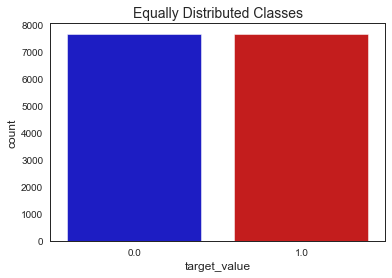

In [92]:
sns.countplot('target_value', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

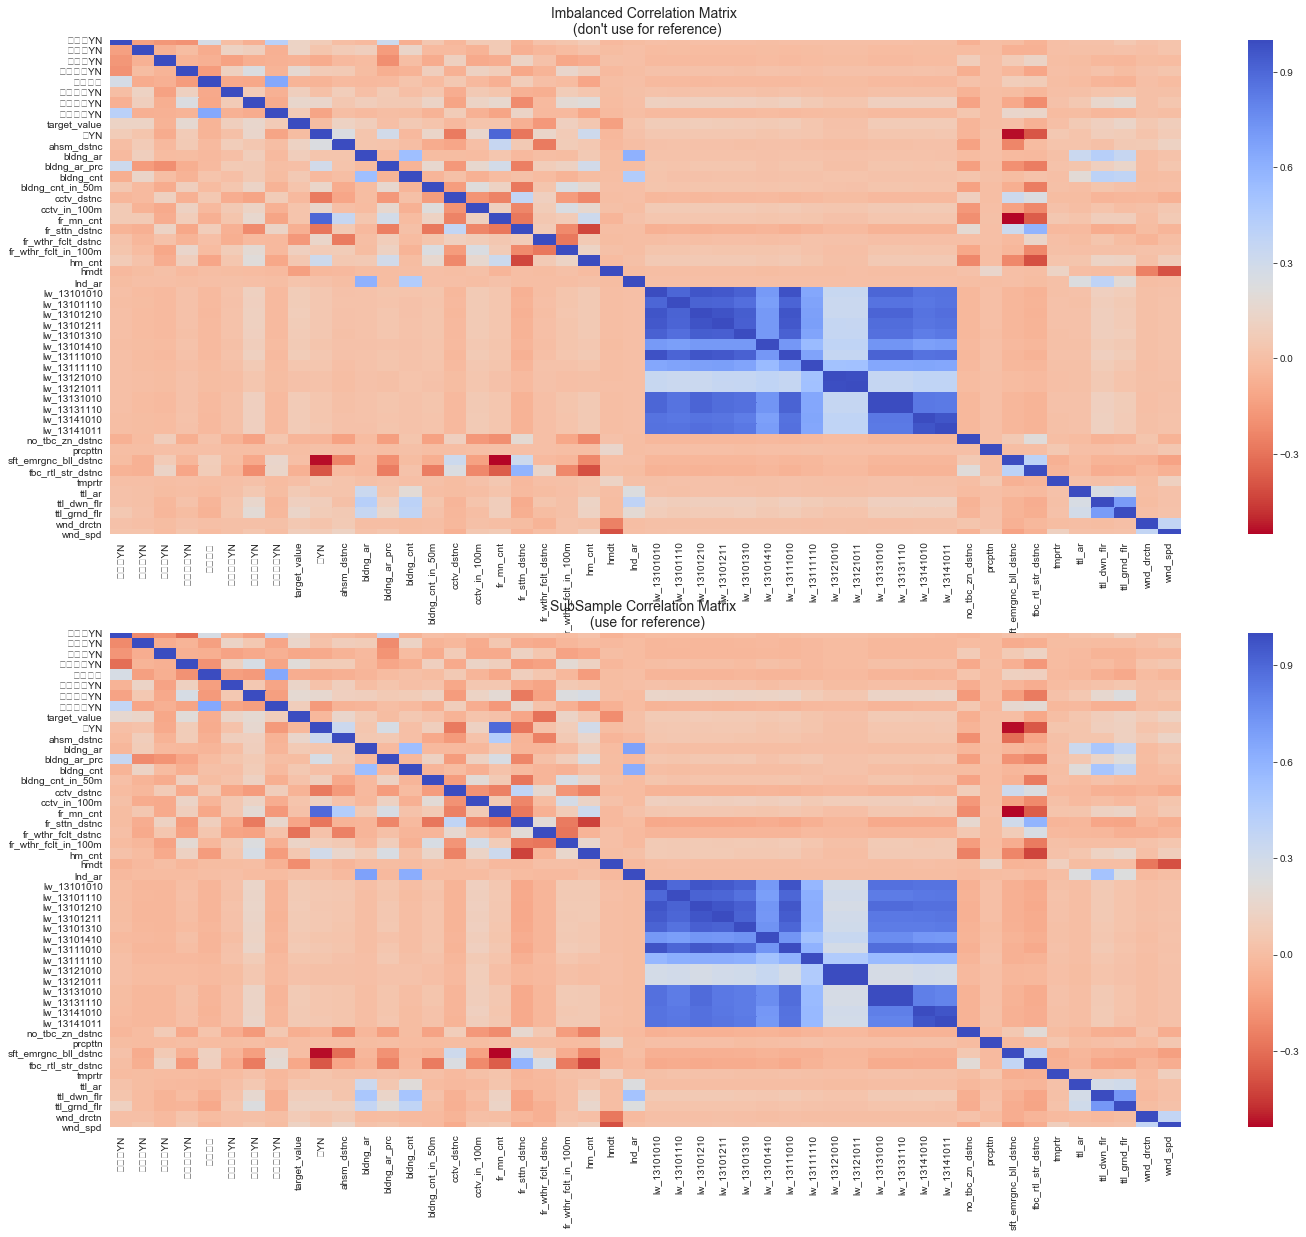

In [93]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

# New_df is from the random undersample data (fewer instances)
X_us = new_df.drop('target_value', axis=1)
y_us = new_df['target_value']

In [94]:
# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [95]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [96]:
# Wow our scores are getting even high scores even when applying cross validation.

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 4) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 71.72 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 74.26 % accuracy score
Classifiers:  SVC Has a training score of 78.17 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 75.8 % accuracy score


In [97]:
best_xgb_model = xgboost.XGBClassifier(colsample_bytree=0.4,
                 gamma=0.3,                 
                 learning_rate=0.1,
                 max_depth=5,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=1e-05,
                 reg_lambda=0.01,
                 subsample=0.95,
                 )

best_xgb_model.fit(X_train,y_train)
training_score = cross_val_score(best_xgb_model, X_train, y_train, cv=5)

KeyboardInterrupt: 

In [98]:
# 가장 우수한 성능을 보이는 SVC

model_SVC=SVC()
model_SVC.fit(X=X_train, y=y_train)

y_pred_SVC = model_SVC.predict(X_test)

In [ ]:
# 선형 커널 만들어보기
from sklearn.svm import LinearSVC
model_LSVC = LinearSVC()
model_LSVC.fit(X_train,y_train)

# proba = model_LSVC.decision_function(X_train)
# prob = (proba - proba.min()) / (proba.max() - proba.min())
# print('Prob[0]: %.3f' % (1-prob[0]))
# print('Prob[1]: %.3f' % (prob[0]))

cross_val_score(model_LSVC, X_train, y_train, cv=5)

In [ ]:
# Logistic Regression model

model_LR =LogisticRegression()
model_LR.fit(X_train, y_train)


y_pred_LR = model_LR.predict(X_test)


model_LR.coef_

In [ ]:
model_RF =RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
model_RF.fit(X_train, y_train)
# Random Forest model

y_pred_RF = model_RF.predict(X_test)

# for name, importance in zip(X_train, model_RF.feature_importances_):
#     print(name, "=", importance)

In [ ]:
X_train1=pd.DataFrame(X_train)

# RF 모델의 피처 중요도 플롯

feat_importances = pd.Series(model_RF.feature_importances_, index=X_train1.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
# y_pred = best_xgb_model.predict(X_test)

y_pred2 = best_xgb_model.predict(X.values)

y_pred2 = model_LSVC.predict(X)

In [104]:
#original_Xtest, original_ytest

예측=model_SVC.predict(original_Xtest)
정답=original_ytest

In [100]:
#original_Xtest, original_ytest

예측=model_SVC.predict(X_test)
정답=y_test

[[6326 3982]
 [  78 1453]]


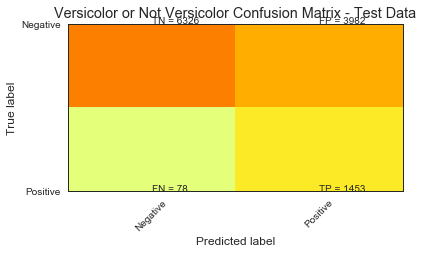

In [163]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(정답, 예측)
print(cm)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Versicolor or Not Versicolor Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [164]:
import sklearn.metrics

print(sklearn.metrics.recall_score(정답,예측))
print(sklearn.metrics.precision_score(정답,예측))

print(sklearn.metrics.accuracy_score(정답,예측))
print("이게중요!",sklearn.metrics.f1_score(정답,예측))
print(sklearn.metrics.precision_recall_curve(정답,예측))

0.9490529065969955
0.2673413063477461
0.6570656305431202
이게중요! 0.4171691070915877
(array([0.12931835, 0.26734131, 1.        ]), array([1.        , 0.94905291, 0.        ]), array([0., 1.]))


# Feature importance

In [ ]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

f_importances(model_SVC.coef_[0], list(X.columns))

In [ ]:
import imblearn

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

In [ ]:
# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

In [ ]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

n_classes=len(y_score)

# Light GBM 

In [131]:
import lightgbm as lgb

In [132]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_error',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

print('Starting training...')

In [138]:
params = {
        'task': 'train',
        'objective': 'binary',    # 2値分類の指定
        'metric': 'binary_error', # 誤答率の割合
        'verbose': 1
}

In [133]:
params = {
    'objective' :'binary',
    'learning_rate' : 0.02,
    'num_leaves' : 76,
    'feature_fraction': 0.64, 
    'bagging_fraction': 0.8, 
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'binary_logloss'
}

In [139]:
gbm = lgb.train(params,
            lgb_train,
            num_boost_round=50,       
            early_stopping_rounds=10,
            valid_sets=[lgb_train,lgb_eval],
            valid_names=['train', 'eval'])

[1]	train's binary_error: 0.182189	eval's binary_error: 0.19001
Training until validation scores don't improve for 10 rounds
[2]	train's binary_error: 0.178843	eval's binary_error: 0.191642
[3]	train's binary_error: 0.17321	eval's binary_error: 0.193928
[4]	train's binary_error: 0.17117	eval's binary_error: 0.187724
[5]	train's binary_error: 0.171088	eval's binary_error: 0.195233
[6]	train's binary_error: 0.168068	eval's binary_error: 0.192295
[7]	train's binary_error: 0.166191	eval's binary_error: 0.190663
[8]	train's binary_error: 0.166762	eval's binary_error: 0.18903
[9]	train's binary_error: 0.167497	eval's binary_error: 0.190336
[10]	train's binary_error: 0.165456	eval's binary_error: 0.192622
[11]	train's binary_error: 0.165538	eval's binary_error: 0.19001
[12]	train's binary_error: 0.165538	eval's binary_error: 0.191969
[13]	train's binary_error: 0.16464	eval's binary_error: 0.190989
[14]	train's binary_error: 0.164803	eval's binary_error: 0.191969
Early stopping, best iteration

# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
# gbm.save_model('model.txt')

print('Starting predicting...')
# predict

In [159]:
예측 = gbm.predict(original_Xtest, num_iteration=gbm.best_iteration)

In [160]:
예측[예측>=0.5]=1

In [161]:
예측[예측<0.5]=0

In [162]:
정답=original_ytest

from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

f_importances(model_SVC.coef_[0], list(X.columns))
import imblearn

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

In [ ]:
test=pd.read_csv("PJT002_test.csv")



object_list=[]
for col in test:
    if test[col].dtype =="object":
        object_list.append(col)

object_list=[]
for i in range(len(data.columns.tolist())):
    if data[data.columns.tolist()[i]].dtype == 'O':
        object_list.append(data.columns.tolist()[i])


object_data=test[object_list[:]]

numeric_list=list(set(test.columns.tolist()) - set(object_list))
numeric_list=sorted(numeric_list)
numeric_data=test[numeric_list[:]]



object_data['dt_of_fr']=object_data['dt_of_fr'].astype('datetime64[ns]')

# object_data.fr_yn=object_data.fr_yn.apply(lambda x: 1 if x=="Y" else 0)


object_data['주거시설YN']=object_data.bldng_us.apply(lambda x: 1 if x=="단독주택" else x)
object_data['주거시설YN']=object_data.주거시설YN.apply(lambda x: 1 if x=="공동주택" else x)
object_data['주거시설YN']=object_data.주거시설YN.apply(lambda x: 1 if x==1 else 0)

object_data['편의시설YN']=object_data.bldng_us.apply(lambda x: 1 if x=="제1종근린생활시설" else x)

object_data['편의시설YN']=object_data.편의시설YN.apply(lambda x: 1 if x=="제2종근린생활시설" else x)

object_data['편의시설YN']=object_data.편의시설YN.apply(lambda x: 1 if x=="문화및집회시설" else x)

object_data['편의시설YN']=object_data.편의시설YN.apply(lambda x: 1 if x==1 else 0)
​

numeric_data_on=numeric_data.iloc[:,[0,1,2,3,4,5,6,68,69,70,71,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158]]